# Approach 0: SVM Baseline (No SMOTE)

Train SVM on embeddings + VADER features **without** SMOTE balancing.
This is the simplest baseline — shows how the model performs on the natural (imbalanced) class distribution.

**Compare with:**
- Approach 1: SVM + SMOTE (`train_svm.ipynb`)
- Approach 2: DistilBERT fine-tuned (`train_distilbert.ipynb`)

In [1]:
import numpy as np
import pandas as pd
import json
import os
import re
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sentence_transformers import SentenceTransformer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Paths
RAW_DATA_PATH = '/home/ram/sentiment_mlops/data/raw/YoutubeCommentsDataSet.csv'
MODEL_PATH = '/home/ram/sentiment_mlops/models/'
os.makedirs(MODEL_PATH, exist_ok=True)

EMBEDDING_MODEL = 'all-MiniLM-L6-v2'

/home/ram/sentiment_mlops/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## 1. Load & Clean Data
df = pd.read_csv(RAW_DATA_PATH)
df['Comment'] = df['Comment'].fillna('').astype(str)

# Keep raw text for VADER
df['raw_comment'] = df['Comment']

def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\.\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Comment'] = df['Comment'].apply(clean_text)
df = df[df['Sentiment'].isin(['positive', 'negative', 'neutral'])]

label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
inv_label_map = {v: k for k, v in label_map.items()}
df['label'] = df['Sentiment'].map(label_map)

print(f'Total samples: {len(df)}')
print(f'\nClass distribution (IMBALANCED — no SMOTE):')
print(df['Sentiment'].value_counts())
print(f'\nImbalance ratio: {df["Sentiment"].value_counts().max() / df["Sentiment"].value_counts().min():.1f}x')

Total samples: 18408

Class distribution (IMBALANCED — no SMOTE):
Sentiment
positive    11432
neutral      4638
negative     2338
Name: count, dtype: int64

Imbalance ratio: 4.9x


In [3]:
## 2. Generate Features (Embeddings + VADER)
print('[1/2] Generating sentence embeddings...')
st_model = SentenceTransformer(EMBEDDING_MODEL)
embeddings = st_model.encode(df['Comment'].tolist(), show_progress_bar=True)

print('[2/2] Extracting VADER features...')
analyzer = SentimentIntensityAnalyzer()
vader_features = []
for text in df['raw_comment']:
    s = analyzer.polarity_scores(text)
    vader_features.append([s['compound'], s['pos'], s['neg'], s['neu']])
vader_features = np.array(vader_features)

# Combine: 384-d embeddings + 4-d VADER = 388-d
scaler_vader = StandardScaler()
vader_scaled = scaler_vader.fit_transform(vader_features)
X = np.hstack([embeddings, vader_scaled])
y = df['label'].values

print(f'\nFeature matrix: {X.shape}')

[1/2] Generating sentence embeddings...


Loading weights: 100%|██████████| 103/103 [00:00<00:00, 275.32it/s, Materializing param=pooler.dense.weight]                             
BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Batches: 100%|██████████| 576/576 [00:11<00:00, 48.46it/s] 


[2/2] Extracting VADER features...

Feature matrix: (18408, 388)


In [4]:
## 3. Train/Test Split (NO SMOTE)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f'Train: {X_train.shape}, Test: {X_test.shape}')
print(f'\nTrain class distribution (imbalanced):')
for label_id in sorted(inv_label_map.keys()):
    count = (y_train == label_id).sum()
    print(f'  {inv_label_map[label_id]:10s}: {count:5d} ({count/len(y_train)*100:.1f}%)')

Train: (14726, 388), Test: (3682, 388)

Train class distribution (imbalanced):
  positive  :  9146 (62.1%)
  neutral   :  3710 (25.2%)
  negative  :  1870 (12.7%)


In [5]:
## 4. Scale & Train SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print('Training SVM (no SMOTE — imbalanced data)...')
svm_baseline = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    probability=True,
    random_state=42,
    verbose=True
)
svm_baseline.fit(X_train_scaled, y_train)
print('\nTraining complete!')

Training SVM (no SMOTE — imbalanced data)...
[LibSVM]....*..*
optimization finished, #iter = 6358
obj = -2561.750131, rho = -0.725933
nSV = 4784, nBSV = 2588
Total nSV = 4784
....*..*
optimization finished, #iter = 6351
obj = -2532.083087, rho = -0.777449
nSV = 4726, nBSV = 2515
Total nSV = 4726
....*..*
optimization finished, #iter = 6205
obj = -2502.074388, rho = -0.677651
nSV = 4699, nBSV = 2490
Total nSV = 4699
....*..*
optimization finished, #iter = 6457
obj = -2571.298468, rho = -0.659474
nSV = 4808, nBSV = 2554
Total nSV = 4808
....*..*
optimization finished, #iter = 6414
obj = -2550.319595, rho = -0.668317
nSV = 4771, nBSV = 2536
Total nSV = 4771
.....*..*
optimization finished, #iter = 7821
obj = -3145.365730, rho = 0.725721
nSV = 5780, nBSV = 3138
..*.*
optimization finished, #iter = 3494
obj = -1163.781257, rho = 0.227695
nSV = 2521, nBSV = 1121
Total nSV = 2521
..*.*
optimization finished, #iter = 3637
obj = -1141.289719, rho = 0.183083
nSV = 2510, nBSV = 1058
Total nSV = 2

In [6]:
## 5. Evaluate on Test Set
y_pred = svm_baseline.predict(X_test_scaled)

acc = accuracy_score(y_test, y_pred)
print(f'\n{"="*50}')
print(f'  TEST ACCURACY (No SMOTE): {acc:.4f} ({acc*100:.1f}%)')
print(f'{"="*50}\n')

target_names = [inv_label_map[i] for i in sorted(inv_label_map.keys())]
print(classification_report(y_test, y_pred, target_names=target_names))


  TEST ACCURACY (No SMOTE): 0.8015 (80.1%)

              precision    recall  f1-score   support

    positive       0.87      0.90      0.88      2286
     neutral       0.67      0.66      0.67       928
    negative       0.71      0.62      0.66       468

    accuracy                           0.80      3682
   macro avg       0.75      0.72      0.74      3682
weighted avg       0.80      0.80      0.80      3682



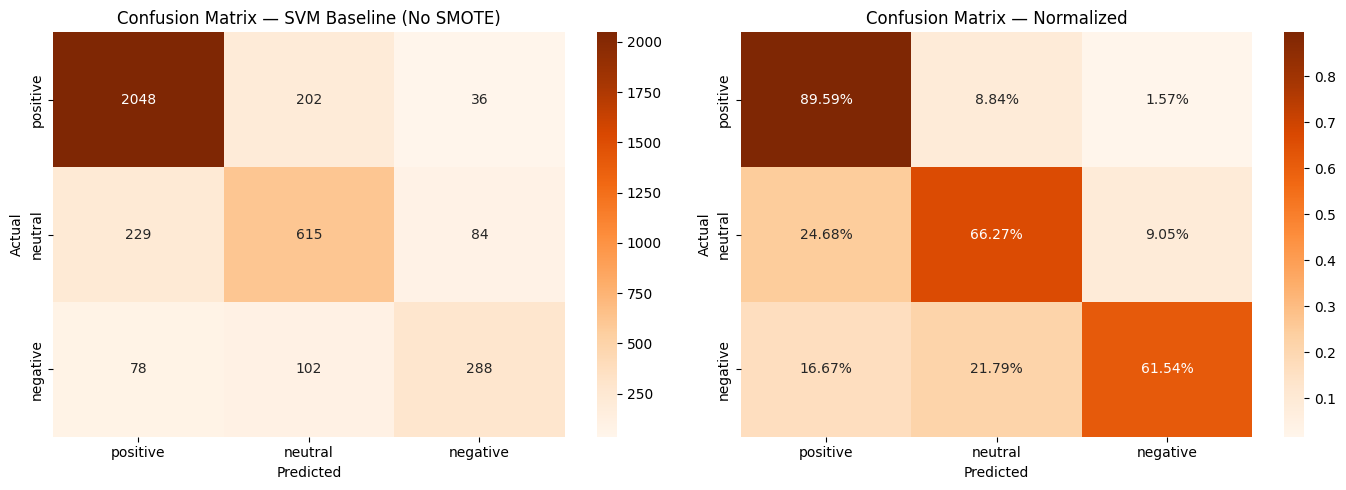

Per-class recall (sensitivity):
  positive  : 89.6%
  neutral   : 66.3%
  negative  : 61.5%


In [7]:
## 6. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names, ax=axes[0])
axes[0].set_title('Confusion Matrix — SVM Baseline (No SMOTE)')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Oranges',
            xticklabels=target_names, yticklabels=target_names, ax=axes[1])
axes[1].set_title('Confusion Matrix — Normalized')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# Highlight per-class recall (critical for imbalanced data)
print('Per-class recall (sensitivity):')
for i, name in enumerate(target_names):
    recall = cm_norm[i, i]
    flag = ' ⚠️ LOW' if recall < 0.5 else ''
    print(f'  {name:10s}: {recall:.1%}{flag}')

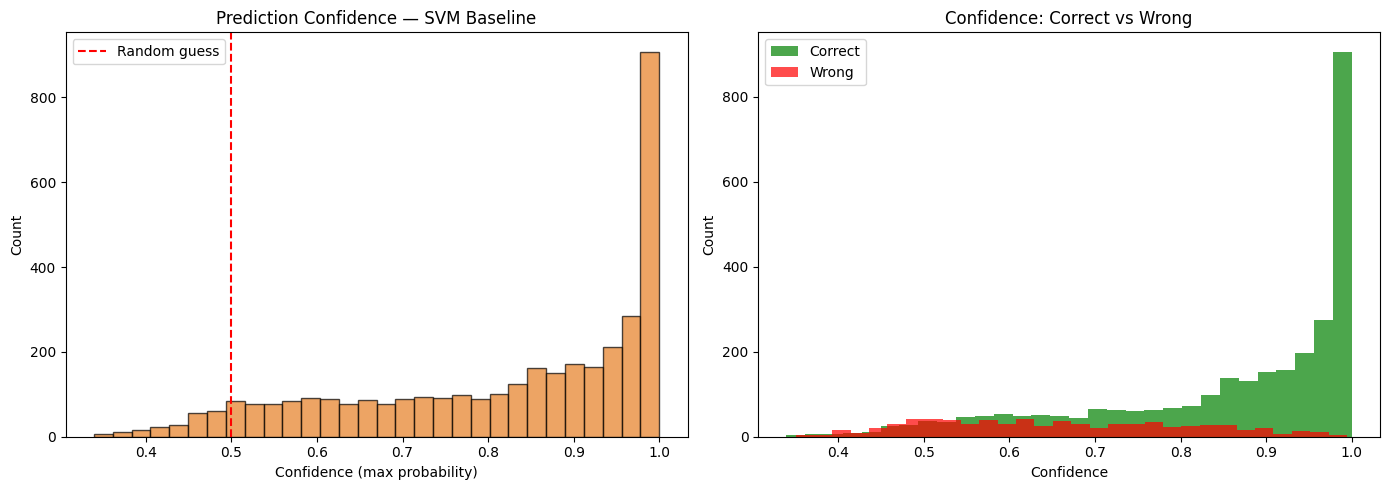

Mean confidence (correct): 0.859
Mean confidence (wrong):   0.656


In [8]:
## 7. Confidence Distribution
y_proba = svm_baseline.predict_proba(X_test_scaled)
y_confidence = y_proba.max(axis=1)
correct_mask = y_pred == y_test

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(y_confidence, bins=30, edgecolor='black', alpha=0.7, color='#e67e22')
axes[0].set_title('Prediction Confidence — SVM Baseline')
axes[0].set_xlabel('Confidence (max probability)')
axes[0].set_ylabel('Count')
axes[0].axvline(x=0.5, color='red', linestyle='--', label='Random guess')
axes[0].legend()

axes[1].hist(y_confidence[correct_mask], bins=30, alpha=0.7, label='Correct', color='green')
axes[1].hist(y_confidence[~correct_mask], bins=30, alpha=0.7, label='Wrong', color='red')
axes[1].set_title('Confidence: Correct vs Wrong')
axes[1].set_xlabel('Confidence')
axes[1].set_ylabel('Count')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'Mean confidence (correct): {y_confidence[correct_mask].mean():.3f}')
print(f'Mean confidence (wrong):   {y_confidence[~correct_mask].mean():.3f}')

In [9]:
## 8. Save Baseline Model
joblib.dump(svm_baseline, os.path.join(MODEL_PATH, 'svm_baseline_no_smote.joblib'))
joblib.dump(scaler, os.path.join(MODEL_PATH, 'svm_baseline_scaler.joblib'))

model_info = {
    'model': 'SVM (RBF) — No SMOTE Baseline',
    'accuracy': float(acc),
    'features': 'sentence_embeddings(384) + vader_scaled(4)',
    'feature_dim': int(X_train.shape[1]),
    'train_samples': int(X_train.shape[0]),
    'test_samples': int(X_test.shape[0]),
    'smote': False,
    'label_map': label_map
}
with open(os.path.join(MODEL_PATH, 'svm_baseline_info.json'), 'w') as f:
    json.dump(model_info, f, indent=2)

print('Saved:')
print(f'  Model:  {MODEL_PATH}svm_baseline_no_smote.joblib')
print(f'  Scaler: {MODEL_PATH}svm_baseline_scaler.joblib')
print(f'  Info:   {MODEL_PATH}svm_baseline_info.json')

Saved:
  Model:  /home/ram/sentiment_mlops/models/svm_baseline_no_smote.joblib
  Scaler: /home/ram/sentiment_mlops/models/svm_baseline_scaler.joblib
  Info:   /home/ram/sentiment_mlops/models/svm_baseline_info.json



  MODEL COMPARISON
         Approach  Accuracy (%) SMOTE  Train Samples
0: SVM (No SMOTE)          80.1    No          14726
   1: SVM + SMOTE          79.7   Yes          27438
    2: DistilBERT          85.6   N/A          14726


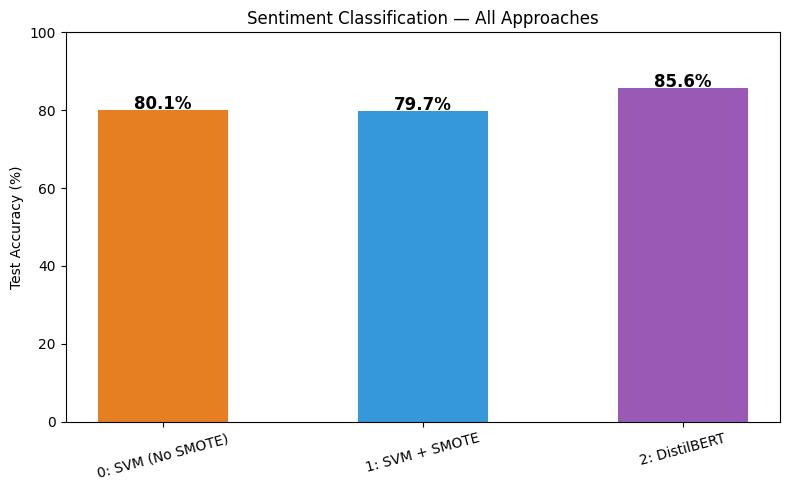

In [10]:
## 9. Compare All Approaches (so far)
print('\n' + '='*65)
print('  MODEL COMPARISON')
print('='*65)

rows = []

# Approach 0 — this notebook
rows.append({
    'Approach': '0: SVM (No SMOTE)',
    'Accuracy (%)': round(acc * 100, 1),
    'SMOTE': 'No',
    'Train Samples': X_train.shape[0]
})

# Approach 1 — SVM + SMOTE
svm_smote_path = os.path.join(MODEL_PATH, 'svm_model_info.json')
if os.path.exists(svm_smote_path):
    with open(svm_smote_path) as f:
        svm_info = json.load(f)
    rows.append({
        'Approach': '1: SVM + SMOTE',
        'Accuracy (%)': round(svm_info['accuracy'] * 100, 1),
        'SMOTE': 'Yes',
        'Train Samples': svm_info['train_samples']
    })

# Approach 2 — DistilBERT
bert_path = os.path.join(MODEL_PATH, 'distilbert_sentiment/model_info.json')
if os.path.exists(bert_path):
    with open(bert_path) as f:
        bert_info = json.load(f)
    rows.append({
        'Approach': '2: DistilBERT',
        'Accuracy (%)': round(bert_info['accuracy'] * 100, 1),
        'SMOTE': 'N/A',
        'Train Samples': bert_info['train_samples']
    })

comparison_df = pd.DataFrame(rows)
print(comparison_df.to_string(index=False))

# Bar chart
if len(rows) > 1:
    colors = ['#e67e22', '#3498db', '#9b59b6'][:len(rows)]
    fig, ax = plt.subplots(figsize=(8, 5))
    bars = ax.bar(comparison_df['Approach'], comparison_df['Accuracy (%)'], color=colors, width=0.5)
    for bar, val in zip(bars, comparison_df['Accuracy (%)']):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{val}%', ha='center', fontsize=12, fontweight='bold')
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_title('Sentiment Classification — All Approaches')
    ax.set_ylim(0, 100)
    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()

In [11]:
## 10. Quick Test — Predict on Sample Comments
def predict_sentiment(texts):
    cleaned = [clean_text(t) for t in texts]
    embs = st_model.encode(cleaned)
    vader = []
    for t in texts:
        s = analyzer.polarity_scores(t)
        vader.append([s['compound'], s['pos'], s['neg'], s['neu']])
    vader = scaler_vader.transform(np.array(vader))
    features = np.hstack([embs, vader])
    features_scaled = scaler.transform(features)
    preds = svm_baseline.predict(features_scaled)
    proba = svm_baseline.predict_proba(features_scaled)
    results = []
    for i, text in enumerate(texts):
        results.append({
            'text': text[:80],
            'prediction': inv_label_map[preds[i]],
            'confidence': f"{proba[i].max():.1%}"
        })
    return pd.DataFrame(results)

test_comments = [
    "This video is absolutely amazing! Best tutorial ever!",
    "Terrible content, waste of my time.",
    "The video is 10 minutes long.",
    "I love how you explained the concept so clearly, subscribed!",
    "Boring and poorly made, dislike.",
    "Can someone tell me the timestamp for the second part?"
]

predict_sentiment(test_comments)

,text,prediction,confidence
0,This video is absolutely amazing! Best tutoria...,positive,100.0%
1,"Terrible content, waste of my time.",negative,99.5%
2,The video is 10 minutes long.,neutral,63.4%
3,I love how you explained the concept so clearl...,positive,98.9%
4,"Boring and poorly made, dislike.",negative,99.5%
5,Can someone tell me the timestamp for the seco...,neutral,90.8%
